# Imports

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import iceberg, metocean, drift_simulation, plot, tools
from icedef.turnbull import drift

# Iceberg

In [38]:
df = pd.read_csv('ftp://data.munroelab.ca/pub/iceberg/beacon/0204980_2015.csv')

df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

times = [t.to_pydatetime() for t in df['DataDate_UTC']]

max_hr = 24
dt_vec = np.asarray([(time - times[0]).days*24 + (time - times[0]).seconds/3600 for time in times])
max_hr_indx = np.where(dt_vec < max_hr)[0][-1]

df = df[:max_hr_indx+1]

times = [t.to_pydatetime() for t in df['DataDate_UTC']]
lons = df['Longitude']
lats = df['Latitude']

n = 100

lonn = lons[n]; lon0 = lons[0] 
latn = lats[n]; lat0 = lats[0]

dx, dy = tools.deg2m(lon0, lonn, lat0, latn) 
dist = np.sqrt(dx**2 + dy**2)

tn = times[n]; t0 = times[0]
dt = (tn - t0).days*3600 + (tn - t0).seconds

vx = dx/dt; vy = dy/dt


ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], vx, vy, 0, 0, 'LG', 'TAB')

ref_berg.history['T'] = times; ref_berg.history['X'] = lons; ref_berg.history['Y'] = lats

berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [39]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

atm_data = metocean.NARRAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

### Timesteps

In [40]:
dt = 0.1*3600
t0 = ref_berg.history['T'][0]
tf = ref_berg.history['T'][-1]
tdelta = tf - t0
tdelta_secs = tdelta.days*12*3600 + tdelta.seconds
nt = int(tdelta_secs//dt)

### Simulation

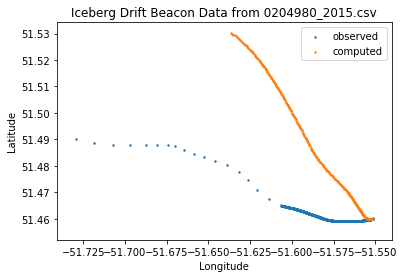

In [41]:
berg = iceberg.clone_iceberg_state(ref_berg)

sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

#sim.euler(dt,nt)
sim.rk2(dt, nt)

# Plot

plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

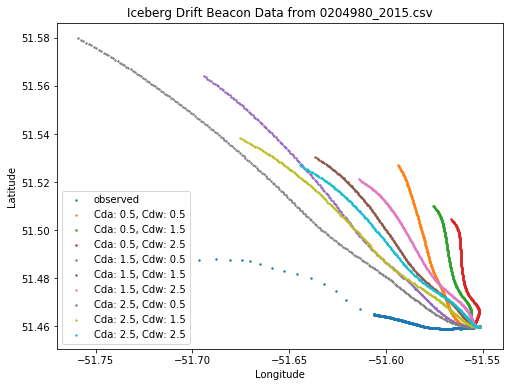

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

drag_vec = [0.5, 1.5, 2.5]

for Cda in drag_vec:
    for Cdw in drag_vec:
    
        berg = iceberg.clone_iceberg_state(ref_berg)
        berg.Cda = Cda
        berg.Cdw = Cdw
        sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)
        sim.rk2(dt, nt)
        plt.scatter(sim.history['x'], sim.history['y'], s=2, label=f'Cda: {Cda}, Cdw: {Cdw}')

plt.legend()
plt.show()

# Animation

### Wind

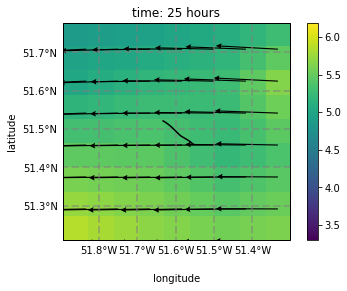

In [57]:
dx_scale = 3
dy_scale = 3
dt_scale = 3
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], atm_data.T_UNITS, atm_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = atm_data.lons
y_grid = atm_data.lats
t_grid = atm_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = atm_data.U
v_data = atm_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, fname='wind_anim', v_auto=True, scale=20, speed=500)

### Current

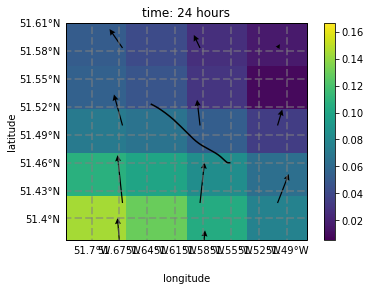

In [56]:
dx_scale = 1
dy_scale = 1
dt_scale = 1
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], ocean_data.T_UNITS, ocean_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = ocean_data.lons
y_grid = ocean_data.lats
t_grid = ocean_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = ocean_data.U
v_data = ocean_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='current_anim', v_auto=True, scale=0.5, speed=500)